Looking for C:\Users\brent\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\brent\.keras-ocr\crnn_kurapan.h5
..\img/Char
1/1 [==============================] - 0s 56ms/step
Already in dict
1/1 [==============================] - 0s 57ms/step
{'p': 'char_0.png', 'r': 'char_1.png', 's': 'char_2.png', 'f': 'char_3.png', 'p0': 'char_4.png', 'c': 'char_5.png', 't': 'char_6.png'}
differential_evolution step 1: f(x)= 90.3359
differential_evolution step 2: f(x)= 89.8061
differential_evolution step 3: f(x)= 89.7892
differential_evolution step 4: f(x)= 89.7881
 message: Optimization terminated successfully.
 success: True
     fun: 89.78810418915047
       x: [ 1.017e+00  9.010e-01 -5.298e-03 -6.418e-01  3.904e-01]
     nit: 4
    nfev: 2560
im1_x: 45, im1_y: 45, image1_data.shape: (30, 17)


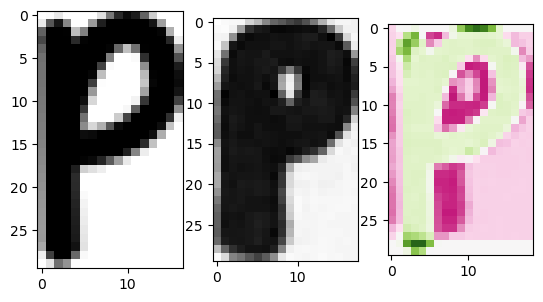

The fun value for these two images is 89.78810418915047
differential_evolution step 1: f(x)= 100.386
differential_evolution step 2: f(x)= 99.7692
differential_evolution step 3: f(x)= 99.7202
differential_evolution step 4: f(x)= 99.6555
differential_evolution step 5: f(x)= 99.6126
 message: Optimization terminated successfully.
 success: True
     fun: 99.61259524905857
       x: [ 8.668e-01  9.823e-01 -3.618e-01  3.830e+00 -5.521e+00]
     nit: 5
    nfev: 3072
im1_x: 45, im1_y: 45, image1_data.shape: (30, 26)


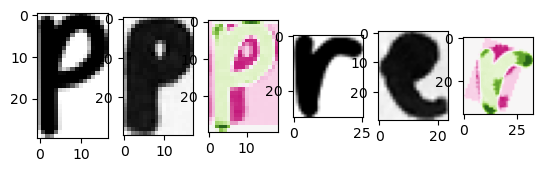

The fun value for these two images is 99.61259524905857
differential_evolution step 1: f(x)= 107.494
differential_evolution step 2: f(x)= 106.877
differential_evolution step 3: f(x)= 106.848
differential_evolution step 4: f(x)= 106.799
differential_evolution step 5: f(x)= 106.768
differential_evolution step 6: f(x)= 106.767
differential_evolution step 7: f(x)= 106.763
 message: Optimization terminated successfully.
 success: True
     fun: 106.76327325773683
       x: [ 1.100e+00  1.139e+00  4.487e-01 -4.552e+00  4.151e+00]
     nit: 7
    nfev: 4096
im1_x: 51, im1_y: 51, image1_data.shape: (30, 22)


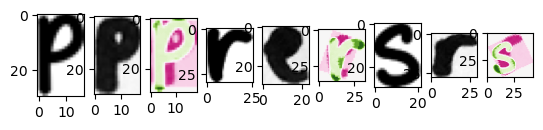

The fun value for these two images is 106.76327325773683
differential_evolution step 1: f(x)= 69.3659
differential_evolution step 2: f(x)= 69.0967
differential_evolution step 3: f(x)= 68.8202
differential_evolution step 4: f(x)= 68.5743
 message: Optimization terminated successfully.
 success: True
     fun: 68.5743056637245
       x: [ 6.264e-01  8.505e-01  9.778e-02  2.804e-01  1.488e+00]
     nit: 4
    nfev: 2560
im1_x: 45, im1_y: 45, image1_data.shape: (30, 13)


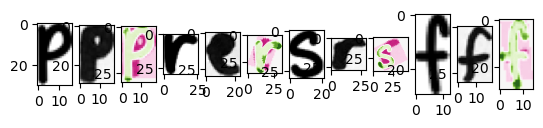

The fun value for these two images is 68.5743056637245
differential_evolution step 1: f(x)= 105.592
differential_evolution step 2: f(x)= 104.623
differential_evolution step 3: f(x)= 104.282
differential_evolution step 4: f(x)= 103.985
 message: Optimization terminated successfully.
 success: True
     fun: 103.98535788709569
       x: [ 6.318e-01  1.024e+00 -2.992e-01  4.830e+00 -1.862e+00]
     nit: 4
    nfev: 2560
im1_x: 46, im1_y: 46, image1_data.shape: (30, 17)


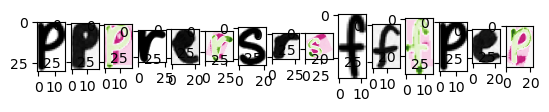

The fun value for these two images is 103.98535788709569
differential_evolution step 1: f(x)= 94.3481
differential_evolution step 2: f(x)= 93.8384


In [ ]:
# Individual characters from image

import cv2
from imutils import contours
import tkinter as tk
from tkinter import ttk
import tkinter.filedialog
import numpy as np
from PIL import Image, ImageTk
import os
import keras_ocr
import os
import imagehash
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
from math import *
from PIL.Image import Resampling
from PIL import Image, ImageOps
from scipy.interpolate import RegularGridInterpolator
import scipy.optimize as opt

global bestfun
bestfun = 200
global avg_fun
avg_fun = 0

# Get handwritten character images from user image
def get_char(file):
    filepath = os.path.abspath(file.name)
    # Load image
    image = cv2.imread(filepath)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Thresholded, separating background from foreground i.e. create a binary image
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Find contours, sort from left-to-right, then crop
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts, _ = contours.sort_contours(cnts, method="left-to-right")

    char_number = 0 # Assign number to each character
    for c in cnts: # For each contour (each character)
        area = cv2.contourArea(c) # Get area of contour
        if area > 100: # Area must be large enough to filter out noise
            x,y,w,h = cv2.boundingRect(c) # Get coordinates of character
            char = 255 - image[y:y+h, x:x+w] # Invert BW
            # Save character as a PNG
            cv2.imwrite(os.path.join('..', 'img', 'char', 'char_{}.png'.format(char_number)), char)
            cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2) # Draw rectangle around character
            char_number += 1
            
    cv2.waitKey()
    identify_char()


# Identify characters from each image and map "character: filename" to a dictionary
def identify_char():
    pipeline = keras_ocr.pipeline.Pipeline() # Load OCR model
    path = os.path.join((os.pardir), "img/Char")##'C://Users//markt//Downloads//HandwritingML-main//HandwritingML-main//img//char'
    
    # Dict stores "character: filename"
    files_and_chars = {} 
    # Iterate through each char image in path
    print(path)
    for filename in os.listdir(path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image = keras_ocr.tools.read(os.path.join(path, filename)) # Load image
            results = pipeline.recognize([image])                      # Recognize char in image

            # Extract recognized character and add to dict
            try:
                character = results[0][0][0]
                if character in files_and_chars:
                    print("Already in dict")
                    num = 0
                    while character in files_and_chars:
                        character += str(num)
                        num += 1
                    files_and_chars[character] = filename
                else:
                    files_and_chars[character] = filename
            except:
                continue
                
    print(files_and_chars)
    compare_char(files_and_chars)

images = []

def show_image(image_data, diff=False, title=None):
    images.append((image_data, diff, title))

def show_diff(image1_data, image2_data, title=None):
    show_image(image1_data - image2_data, True, title)

# show_all_images() is called at the end of the script to display everything in the queue
def show_all_images():
    fig, axs = plt.subplots(1, len(images))
    for i in range(len(images)):
        image_data, diff, title = images[i]
        ax = axs[i] if len(images) > 1 else axs
        ax.set_title(title)
        if diff:
            ax.imshow(image_data, cmap='PiYG', vmin=0, vmax=512)
        else:
            ax.imshow(image_data, cmap='gray')
    plt.show() 
    
def binarize(image_data):
    threshold = 128
    return np.vectorize(lambda x: 0 if x < threshold else 255)(image_data)
    
# Scale the image
def scale(image, factor, resample=Resampling.BICUBIC):
    return image.resize((int(image.width * factor[0]), int(image.height * factor[1])), resample=resample)
    
def rotate(xy, radians):
    r, theta = (hypot(xy[0], xy[1]), atan2(xy[1], xy[0]))
    theta += radians
    return (r * cos(theta), r * sin(theta))

def pad_translated(image_data, dimensions, translate=(0, 0)):
    # print(image_data.shape, dimensions, translate)
    padded_image_data = 255 - np.zeros(dimensions)
    padded_image_data[translate[1] : translate[1]+image_data.shape[0] , translate[0] : translate[0]+image_data.shape[1]] = image_data
    return padded_image_data

# Calculates the difference between two images
def image_rmse(image1_data, image2_data):
    mse = np.power(image2_data - image1_data, 2).mean()
    rmse = sqrt(mse)
    return rmse

# currently in use
# Note: this doesn't give pixel-perfect accuracy (since it's interpolating the scaling backwards), but it works to visualize what is going on
def display_scaled_rotated_translation_diff(image1_data, image2_data, im2_scale_factor, im2_rotation, translate, title=None):
    # perform the following steps to process the transforms:
    # 1. create a square buffer with dimensions 3 times as long as the largest dimension of either image
    # 2. create a RegularGridInterpolator for image2_data
    # 3. for each pixel in the buffer, calculate the corresponding pixel in image2_data by applying the inverse of the transforms to the pixel's coordinate
    # 4. use the RegularGridInterpolator to get that pixel value from image2_data and store it in the buffer.
    # 5. crop the buffer
    biggest_dimension = max(image1_data.shape[0], image2_data.shape[0], image1_data.shape[1], image2_data.shape[1])
    buf_size = int(biggest_dimension*3*max(im2_scale_factor[0], im2_scale_factor[1], 1))
    buf = 255 - np.zeros((buf_size, buf_size))

    x = np.arange(0, image2_data.shape[1])
    y = np.arange(0, image2_data.shape[0])
    f = RegularGridInterpolator((y, x), image2_data, bounds_error=False, fill_value=255, method='linear')
    for i in range(buf.shape[0]):
        for j in range(buf.shape[1]):
            # calculate the corresponding pixel in image2_data
            pixel = (i-buf_size//2, j-buf_size//2)

            # then, translate the pixel's coordinate by -translate
            pixel = (pixel[0] - translate[1], pixel[1] - translate[0])

            # first, rotate the pixel's coordinate by -im2_rotation
            pixel = rotate(pixel, -im2_rotation)

            # then, scale the pixel's coordinate by 1/im2_scale_factor
            pixel = (pixel[0]/im2_scale_factor[1], pixel[1]/im2_scale_factor[0])

            # finally, round the pixel's coordinate to the nearest integer
            pixel = (floor(pixel[0]), floor(pixel[1]))

            # add the offset back
            # pixel = (pixel[0] + int(biggest_dimension*1.5), pixel[1] + int(biggest_dimension*1.5))

            # print(pixel)
            # get the pixel value from image2_data
            try:
                buf[i, j] = f(pixel)
                # print('pixel in bounds: {}'.format(pixel))
            except:
                print('pixel out of bounds: {}'.format(pixel))
                print('image2_data.shape: {}'.format(image2_data.shape))
                return


    # draw image1_data
    im1_x = buf_size//2
    im1_y = buf_size//2
    print(f'im1_x: {im1_x}, im1_y: {im1_y}, image1_data.shape: {image1_data.shape}')

    buf = 255 - buf
    image1_data = 255 - image1_data
    buf[im1_x:im1_x+image1_data.shape[0], im1_y:im1_y+image1_data.shape[1]] -= image1_data
    # buf = 255 - buf


    # crop the buffer
    # buf = 255 - buf
    buf = buf[np.any(buf, axis=1)]
    buf = buf[:, np.any(buf, axis=0)]
    buf = 255 - buf

    # display the difference
    show_image(buf, True)

# translate is (x,y) as opposed to (row, column) and translate is applied after scale
def scaled_rotated_translated_image_rmse3(image1_data, image2_data, im2_scale_factor, im2_rotation, translate):
    image1_interpolator = RegularGridInterpolator((range(image1_data.shape[0]), range(image1_data.shape[1])), image1_data, bounds_error=False, fill_value=255)

    points = np.array([
        rotate((i*im2_scale_factor[1], j*im2_scale_factor[0]), im2_rotation)
            for i in range(image2_data.shape[0]) for j in range(image2_data.shape[1])
    ])
    # translate each point in points
    points = np.array([(i + translate[1], j + translate[0]) for i, j in points])

    window_to_compare_to_image2 = image1_interpolator(points).reshape(image2_data.shape)

    return image_rmse(window_to_compare_to_image2, image2_data)

# 
def set_images(image1_input, image2_input):
    global image1, image2
    image1 = image1_input
    image2 = image2_input


def init_images():
    global image1, image2, image1_data, image2_data

    image1.thumbnail((30,30))
    image1_data = np.array(image1)

    image2_data = np.array(image2)
    
    #image2_data = binarize(image2_data)
    #TODO: Make sure this works

    # crop
    image2_data = 255 - image2_data
    image2_data = image2_data[np.any(image2_data, axis=1)]
    image2_data = image2_data[:, np.any(image2_data, axis=0)]
    image2_data = 255 - image2_data

    image2 = Image.fromarray(image2_data)
    image2.thumbnail((30,30))
    image2_data = np.array(image2)

def compare_translated_images(scale_rotate_translate):
    return scaled_rotated_translated_image_rmse3(image1_data, image2_data, scale_rotate_translate[0:2], scale_rotate_translate[2], scale_rotate_translate[3:])

def calculate_result():
    heights_ratio = image1_data.shape[0] / image2_data.shape[0]
    widths_ratio = image1_data.shape[1] / image2_data.shape[1]

    # intervals to check for each feature with differential evolution optimization
    bounds = [
        (0.8*widths_ratio, 1.5*widths_ratio),          # x scaling
        (0.8*heights_ratio, 1.5*heights_ratio),        # y scaling
        (-pi/7, pi/7),                                 # rotation
        (-image2_data.shape[1], image1_data.shape[1]), # x translation
        (-image2_data.shape[0], image1_data.shape[0])  # y translation
    ]

    # result = opt.differential_evolution(compare_translated_images, bounds, popsize=1000, init='sobol', integrality=(True, True), disp=True, workers=-1, x0=(0,0), strategy='randtobest1bin')

    # the hard work is done by scipy here
    result = opt.differential_evolution(compare_translated_images, bounds, disp=True, workers=1, popsize=100, init='sobol', polish=False, mutation=0.15, recombination=0.95)
    return result

fun_values = []    
    

# Compare handwritten characters from dictionary to font characters
def compare_char(files_and_chars):
    fun_values = []
    
    global avg_fun
    global bestfun
    # Iterate through each char image in path
    for key, val in files_and_chars.items():
        written_path = os.path.join((os.pardir), "img/Char")
        written_path += ("/" + val)

        font_path = os.path.join((os.pardir), "fonts/hynings") # Path to font images
        font_path += ("/" + key[0] + ".png")                   # Append filename to path

        image1 = Image.open(written_path).convert("L")
        image1 = ImageOps.invert(image1)
        image2 = Image.open(font_path).convert("L")

        set_images(image2, image1) # 
        init_images()
        result = calculate_result()

        print(result)

        fun_values.append(result.fun)

        show_image(image1_data)
        show_image(image2_data)

        display_scaled_rotated_translation_diff(image1_data, image2_data, result.x[0:2], result.x[2], (floor(result.x[3]), floor(result.x[4])))

        show_all_images()
        images = []
        
        #finding best fun score
        if result.fun < bestfun:
            bestfun = result.fun
            best_written = image1
            best_font = image2
        print(f"The fun value for these two images is {result.fun}")

    # Get the average fun score
    fun_values.sort(reverse=True)
    print(fun_values)
    halved = len(fun_values) // 2
    print(halved)
    fun_values = fun_values[:halved]
    print(fun_values)
    fun_sum = 0
    for i in fun_values:
        fun_sum += i
    avg_fun = fun_sum / halved
        
    #Saving Best Images to local directory
    best_written.save(os.path.join((os.pardir), "img/test/char_hand.png"))
    best_font.save(os.path.join((os.pardir), "img/test/char_font.png"))
    with open(os.path.join((os.pardir), "img/test/test1.txt"), 'w') as resultFile:
        resultFile.write(f"{avg_fun}")
    resultFile.close()
    with open(os.path.join((os.pardir), "img/test/test2.txt"), 'w') as resultFile:
        resultFile.write(f"{bestfun}")
    resultFile.close()
    return bestfun, avg_fun

#function for taking in file to pass to analyzer functions
def open_file():
        file = tk.filedialog.askopenfile(filetypes =[('Image Files', '*.png'),('Image Files', '*.JPG')])
        get_char(file)
 
LARGEFONT =("Verdana", 35)

class MainApp(tk.Tk):
     
    # __init__ function for class tkinterApp
    def __init__(self, *args, **kwargs):
         
        # __init__ function for class Tk
        tk.Tk.__init__(self, *args, **kwargs)
         
        # creating a container
        container = tk.Frame(self) 
        container.pack(fill = "both", expand = True)
  
        container.grid_rowconfigure(0, weight = 1)
        container.grid_columnconfigure(0, weight = 1)
  
        # initializing frames to an empty array
        self.frames = {} 
  
        # iterating through a tuple consisting
        # of the different page layouts
        for F in (StartPage, Results):
  
            frame = F(container, self)
  
            # initializing frame of that object from
            # startpage, results respectively with
            # for loop
            self.frames[F] = frame
  
            frame.grid(row = 0, column = 0, sticky ="nsew")
  
        self.show_frame(StartPage)
  
    # to display the current frame passed as
    # parameter
    def show_frame(self, cont):
        frame = self.frames[cont]
        frame.tkraise()
 
  
# first window frame startpage
  
class StartPage(tk.Frame):
    global avg_fun
    global bestfun
    
    def __init__(self, parent, controller):
        tk.Frame.__init__(self, parent)
        
        global avg_fun
        global bestfun
        
        # label of frame Layout
        label = ttk.Label(self, text ="HandwritingML", font = LARGEFONT)
        author = ttk.Label(self, text ="By Brent Melby, Joseph Cagle and Alex Robey")
        
        # putting the grid in its place by using
        # grid
        label.grid(row = 1, column = 2, padx = 10, pady = 10)
        author.grid(row = 2, column = 2, padx = 10, pady = 10)
        
        #Instructions for User
        greeting = tk.Label(self, text="Please upload an image file containing a single line of handwritten text you wish to compare.\nAcceptable formats are JPG and PNG.")
        greeting.grid(row = 3, column = 2, padx = 10, pady = 10)
  

        #File Explorer
        button1 = ttk.Button(self, text ="Open File",
        command = lambda : [self.open_file(), controller.show_frame(Results)])
        # putting the button in its place by
        # using grid
        button1.grid(row = 4, column = 2, padx = 10, pady = 10)
        
      
    def open_file(self):
        global avg_fun
        global bestfun
        file = tk.filedialog.askopenfile(filetypes =[('Image Files', '*.png'),('Image Files', '*.JPG')])
        get_char(file)
  
# second window frame page1
class Results(tk.Frame):

    def __init__(self, parent, controller):
        
        #Page initializer
        tk.Frame.__init__(self, parent)
        label = ttk.Label(self, text ="Results", font = LARGEFONT)
        spacer = ttk.Label(self, text =" ", font = LARGEFONT)
        label.grid(row = 1, column = 3, pady = 10, columnspan = 3)
        spacer.grid(row = 1, column = 2, pady = 5)
        
        # Load the images using PIL
        imgFont = Image.open(os.path.join((os.pardir), "img//test//char_font.png"))

        # Convert the PIL images to PhotoImage
        photoChar = ImageTk.PhotoImage(file = (os.path.join((os.pardir), "img//test//char_hand.png")))
        photoFont = ImageTk.PhotoImage(file = (os.path.join((os.pardir), "img//test//char_font.png")))
        testfile1 = open (os.path.join((os.pardir), "img//test//test1.txt"), "r")
        avg_fun = testfile1.read()
        testfile2 = open (os.path.join((os.pardir), "img//test//test2.txt"), "r")
        bestfun = testfile2.read()

        # Create the labels using PhotoImage
        imglabel1 = ttk.Label(self, image=photoChar)
        imglabel2 = ttk.Label(self, image=photoFont)
        #Setting labels to the converted photos
        imglabel1.image = photoChar
        imglabel2.image = photoFont
        #Setting labels in page grid
        imglabel1.grid(row = 2, column = 4, sticky="nsew")
        imglabel2.grid(row = 3, column = 4, sticky="nsew")
        
        
        #Scoring Results Display
        result1 = ttk.Label(self, text =f"Your Best Character:")
        result2 = ttk.Label(self, text =f"    The Closest Font Equivalent:")
        result3 = ttk.Label(self, text =f"Average Score: {float(avg_fun):.3f} Best Score: {float(bestfun):.3f}")
        result4 = ttk.Label(self, text =f"Your handwriting on average, scored {float(avg_fun):.3f}. A score below 90 is considered good.\nWith your best score being {float(bestfun):.3f}")
        #return to menu button
        button1 = ttk.Button(self, text ="Return to Menu",
                            command = lambda : controller.show_frame(StartPage))

        result1.grid(row = 2, column = 3, padx = 10, pady = 5)
        result2.grid(row = 3, column = 3, padx = 10, pady = 5)
        result3.grid(row = 4, column = 3, padx = 10, pady = 5)
        result4.grid(row = 5, column = 3, padx = 5, pady = 5, sticky= "nsew")
        # putting the button in its place
        # by using grid
        button1.grid(row = 6, column = 3, padx = 10, pady = 10)

        
# Driver Code
app = MainApp()
app.title("HandwritingML")
app.mainloop()